In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib
from statsmodels.tsa.stattools import adfuller 
import datetime
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.dates as mdates

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Analisis Preliminar Datos para ML - Series de Tiempo

In [4]:
taxis = pd.read_parquet('../ETL/taxis_def.parquet')

In [5]:
taxis

,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,...,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,type,trip_type,pickup_datetime,dropoff_datetime,duration
0,1,0.80,1.0,N,163,230,3.0,6.50,3.5,0.5,...,0.0,1.0,11.50,2.5,0.0,yellow,1.0,2023-09-01 00:15:37,2023-09-01 00:20:21,4.733333
1,2,2.34,1.0,N,236,233,2.0,14.20,1.0,0.5,...,0.0,1.0,21.20,2.5,0.0,yellow,1.0,2023-09-01 00:18:40,2023-09-01 00:30:28,11.800000
2,1,1.62,1.0,N,162,236,2.0,8.60,1.0,0.5,...,0.0,1.0,15.60,2.5,0.0,yellow,1.0,2023-09-01 00:35:01,2023-09-01 00:39:04,4.050000
3,1,0.74,1.0,N,141,229,2.0,5.10,1.0,0.5,...,0.0,1.0,11.10,2.5,0.0,yellow,1.0,2023-09-01 00:45:45,2023-09-01 00:47:37,1.866667
7,1,3.90,1.0,N,140,7,2.0,20.50,3.5,0.5,...,0.0,1.0,31.85,2.5,0.0,yellow,1.0,2023-09-01 00:01:04,2023-09-01 00:18:36,17.533333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40176763,1,0.00,1.0,N,145,7,2.0,19.85,0.0,0.0,...,0.0,1.0,24.51,2.5,0.0,green,1.0,2024-08-31 18:13:00,2024-08-31 18:31:00,18.000000
40176767,1,1.78,1.0,N,129,7,2.0,17.86,0.0,0.0,...,0.0,1.0,21.86,2.5,0.0,green,1.0,2024-08-31 21:39:00,2024-08-31 21:56:00,17.000000
40176768,1,3.27,1.0,N,255,65,2.0,23.95,0.0,0.0,...,0.0,1.0,29.84,2.5,0.0,green,1.0,2024-08-31 22:59:00,2024-08-31 23:19:00,20.000000
40176769,1,2.50,1.0,N,244,41,2.0,20.09,0.0,0.0,...,0.0,1.0,21.09,2.5,0.0,green,1.0,2024-08-31 22:26:00,2024-08-31 22:42:00,16.000000


# Series de Tiempo

In [7]:
taxis.drop(columns=['store_and_fwd_flag','extra','fare_amount','mta_tax','tip_amount',
                    'tolls_amount','improvement_surcharge','congestion_surcharge','Airport_fee','RatecodeID'], inplace=True)

In [8]:
taxis['type'] = taxis['type'].apply(lambda x : 1 if x=='yellow' else 2)

In [9]:
taxis['n_trips'] = 1

In [10]:
taxis

,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,total_amount,type,trip_type,pickup_datetime,dropoff_datetime,duration,n_trips
0,1,0.80,163,230,3.0,11.50,1,1.0,2023-09-01 00:15:37,2023-09-01 00:20:21,4.733333,1
1,2,2.34,236,233,2.0,21.20,1,1.0,2023-09-01 00:18:40,2023-09-01 00:30:28,11.800000,1
2,1,1.62,162,236,2.0,15.60,1,1.0,2023-09-01 00:35:01,2023-09-01 00:39:04,4.050000,1
3,1,0.74,141,229,2.0,11.10,1,1.0,2023-09-01 00:45:45,2023-09-01 00:47:37,1.866667,1
7,1,3.90,140,7,2.0,31.85,1,1.0,2023-09-01 00:01:04,2023-09-01 00:18:36,17.533333,1
...,...,...,...,...,...,...,...,...,...,...,...,...
40176763,1,0.00,145,7,2.0,24.51,2,1.0,2024-08-31 18:13:00,2024-08-31 18:31:00,18.000000,1
40176767,1,1.78,129,7,2.0,21.86,2,1.0,2024-08-31 21:39:00,2024-08-31 21:56:00,17.000000,1
40176768,1,3.27,255,65,2.0,29.84,2,1.0,2024-08-31 22:59:00,2024-08-31 23:19:00,20.000000,1
40176769,1,2.50,244,41,2.0,21.09,2,1.0,2024-08-31 22:26:00,2024-08-31 22:42:00,16.000000,1


In [11]:
taxis_s = taxis.drop(columns=['PULocationID','DOLocationID','dropoff_datetime','payment_type','type','trip_type'])

In [12]:
taxis_s

,passenger_count,trip_distance,total_amount,pickup_datetime,duration,n_trips
0,1,0.80,11.50,2023-09-01 00:15:37,4.733333,1
1,2,2.34,21.20,2023-09-01 00:18:40,11.800000,1
2,1,1.62,15.60,2023-09-01 00:35:01,4.050000,1
3,1,0.74,11.10,2023-09-01 00:45:45,1.866667,1
7,1,3.90,31.85,2023-09-01 00:01:04,17.533333,1
...,...,...,...,...,...,...
40176763,1,0.00,24.51,2024-08-31 18:13:00,18.000000,1
40176767,1,1.78,21.86,2024-08-31 21:39:00,17.000000,1
40176768,1,3.27,29.84,2024-08-31 22:59:00,20.000000,1
40176769,1,2.50,21.09,2024-08-31 22:26:00,16.000000,1


In [13]:
diario = taxis_s.resample('D', on = 'pickup_datetime').sum()

In [14]:
diario

,passenger_count,trip_distance,total_amount,duration,n_trips
pickup_datetime,,,,,
2023-08-25,1,1.80,16.32,9.383333,1
2023-08-26,1,1.68,17.52,11.650000,1
2023-08-27,0,0.00,0.00,0.000000,0
2023-08-28,2,0.01,22.80,0.066667,2
2023-08-29,1,4.04,30.24,10.416667,1
...,...,...,...,...,...
2024-09-06,0,0.00,0.00,0.000000,0
2024-09-07,0,0.00,0.00,0.000000,0
2024-09-08,0,0.00,0.00,0.000000,0


In [15]:
semanal = taxis_s.resample('W', on = 'pickup_datetime').sum()

In [16]:
semanal.head()

,passenger_count,trip_distance,total_amount,duration,n_trips
pickup_datetime,,,,,
2023-08-27,2,3.48,33.84,2.103333e+01,2
2023-09-03,269789,326037.65,3581465.58,2.044612e+06,189053
2023-09-10,774580,941741.78,11635454.86,6.986193e+06,588642
2023-09-17,782870,959974.79,12179688.56,7.395936e+06,606553
2023-09-24,341409,416200.11,5594414.93,3.412822e+06,276622


In [17]:
semanal.shape[0]

56

In [18]:
mensual = taxis_s.resample('M', on = 'pickup_datetime').sum()

In [19]:
mensual

,passenger_count,trip_distance,total_amount,duration,n_trips
pickup_datetime,,,,,
2023-08-31,34,44.67,431.14,2.503167e+02,20
2023-09-30,2834965,3460189.95,43351361.13,2.606321e+07,2179200
2023-10-31,3576133,4382900.21,54676872.61,3.301915e+07,2736389
2023-11-30,3427883,4139501.57,51979545.55,3.135258e+07,2616757
2023-12-31,3541070,4167204.54,51955671.11,3.122333e+07,2625768
2024-01-31,3104773,3883527.49,46044469.28,2.626918e+07,2409342
2024-02-29,3124501,3959766.71,47253940.40,2.747364e+07,2448952
2024-03-31,3628203,4703052.88,55237790.42,3.265720e+07,2858661
2024-04-30,3513134,4646128.88,54112655.33,3.226751e+07,2777362


Se borro agosto del 2023 y septiembre del 2024

In [20]:
diario.drop(diario[(diario.index.year==2023)&(diario.index.month==8)].index,inplace=True)
diario.drop(diario[(diario.index.year==2024)&(diario.index.month==9)].index,inplace=True)

In [21]:
semanal.drop(semanal[(semanal.index.year==2023)&(semanal.index.month==8)].index,inplace=True)
semanal.drop(semanal[(semanal.index.year==2024)&(semanal.index.month==9)].index,inplace=True)

In [22]:
mensual.drop(mensual[(mensual.index.year==2023)&(mensual.index.month==8)].index,inplace=True)
mensual.drop(mensual[(mensual.index.year==2024)&(mensual.index.month==9)].index,inplace=True)

In [23]:
diario

,passenger_count,trip_distance,total_amount,duration,n_trips
pickup_datetime,,,,,
2023-09-01,89276,110263.96,1276806.75,732888.533333,65751
2023-09-02,93982,112062.43,1198955.93,688208.400000,63961
2023-09-03,86499,103670.07,1105305.60,623286.116667,59323
2023-09-04,72679,89044.48,925141.30,486316.350000,51608
2023-09-05,99802,125552.34,1540935.85,897552.166667,78924
...,...,...,...,...,...
2024-08-27,91633,120296.62,1418567.88,824168.966667,73266
2024-08-28,101202,130843.35,1570150.82,920402.516667,81088
2024-08-29,96395,124708.58,1498053.45,894715.883333,76483


In [24]:
semanal

,passenger_count,trip_distance,total_amount,duration,n_trips
pickup_datetime,,,,,
2023-09-03,269789,326037.65,3581465.58,2.044612e+06,189053
2023-09-10,774580,941741.78,11635454.86,6.986193e+06,588642
2023-09-17,782870,959974.79,12179688.56,7.395936e+06,606553
2023-09-24,341409,416200.11,5594414.93,3.412822e+06,276622
2023-10-01,771602,944911.79,11838656.66,7.086461e+06,595336
2023-10-08,801099,981060.43,12204336.29,7.349261e+06,611780
2023-10-15,792958,965088.12,12042382.50,7.287548e+06,604932
2023-10-22,833690,1025976.55,12831777.30,7.789044e+06,638659
2023-10-29,838860,1030375.53,12954809.18,7.852571e+06,643674


In [25]:
mensual

,passenger_count,trip_distance,total_amount,duration,n_trips
pickup_datetime,,,,,
2023-09-30,2834965,3460189.95,43351361.13,2.606321e+07,2179200
2023-10-31,3576133,4382900.21,54676872.61,3.301915e+07,2736389
2023-11-30,3427883,4139501.57,51979545.55,3.135258e+07,2616757
2023-12-31,3541070,4167204.54,51955671.11,3.122333e+07,2625768
2024-01-31,3104773,3883527.49,46044469.28,2.626918e+07,2409342
2024-02-29,3124501,3959766.71,47253940.40,2.747364e+07,2448952
2024-03-31,3628203,4703052.88,55237790.42,3.265720e+07,2858661
2024-04-30,3513134,4646128.88,54112655.33,3.226751e+07,2777362
2024-05-31,3665269,4793006.98,57431400.26,3.453748e+07,2899539


## Estacionalidad

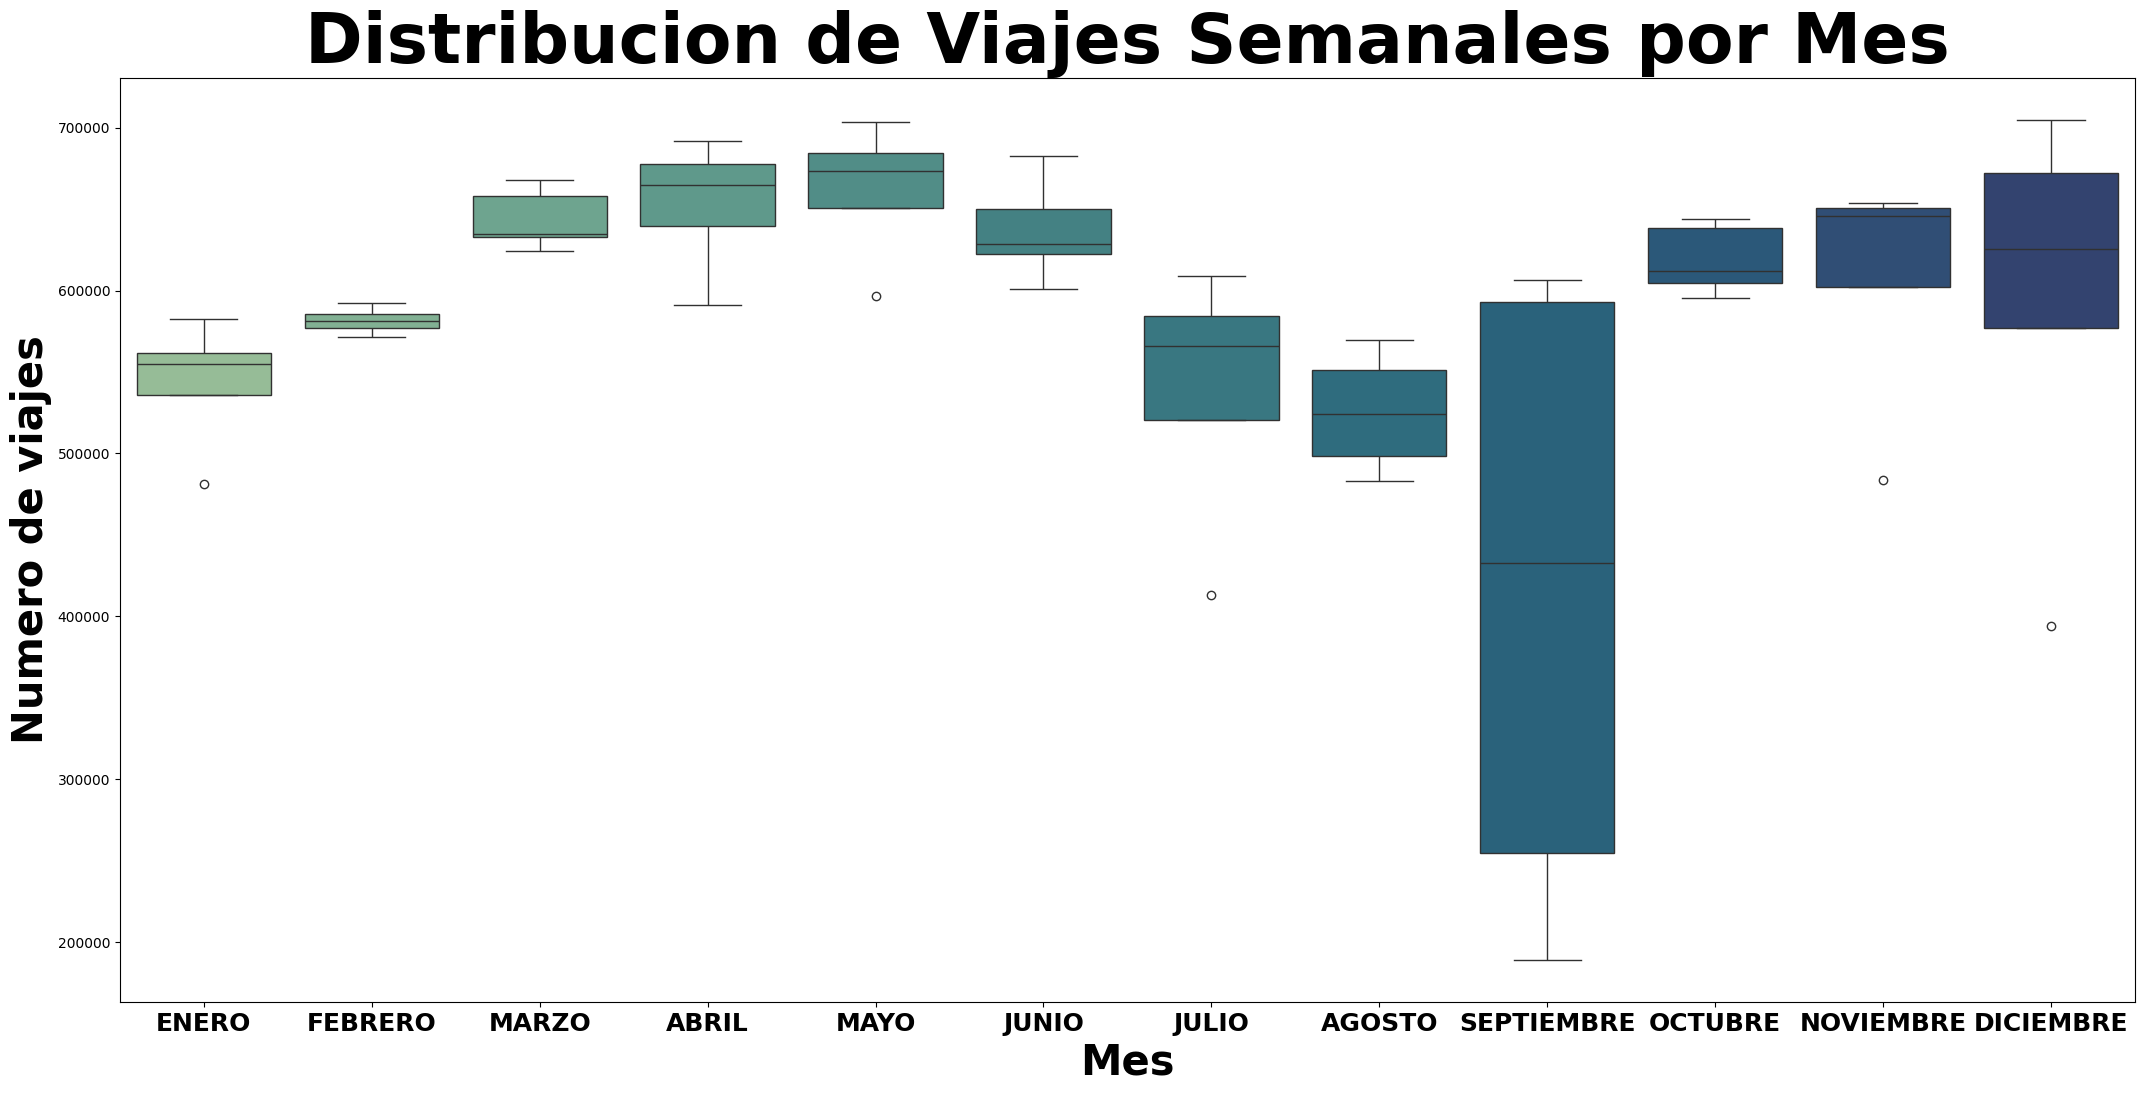

In [26]:
plt.figure(figsize = (26,12))
sns.boxplot(data=semanal,x=semanal.index.month,y= semanal.n_trips, palette='crest')
plt.title('Distribucion de Viajes Semanales por Mes',fontsize = 50,fontweight='bold')
plt.xlabel('Mes',fontsize = 30,fontweight='bold')
plt.ylabel('Numero de viajes',fontsize = 30,fontweight='bold')
plt.xticks(ticks=range(0,12), labels=['ENERO','FEBRERO','MARZO','ABRIL','MAYO','JUNIO','JULIO','AGOSTO','SEPTIEMBRE','OCTUBRE','NOVIEMBRE','DICIEMBRE'], fontsize = 18,fontweight='bold')
plt.show()

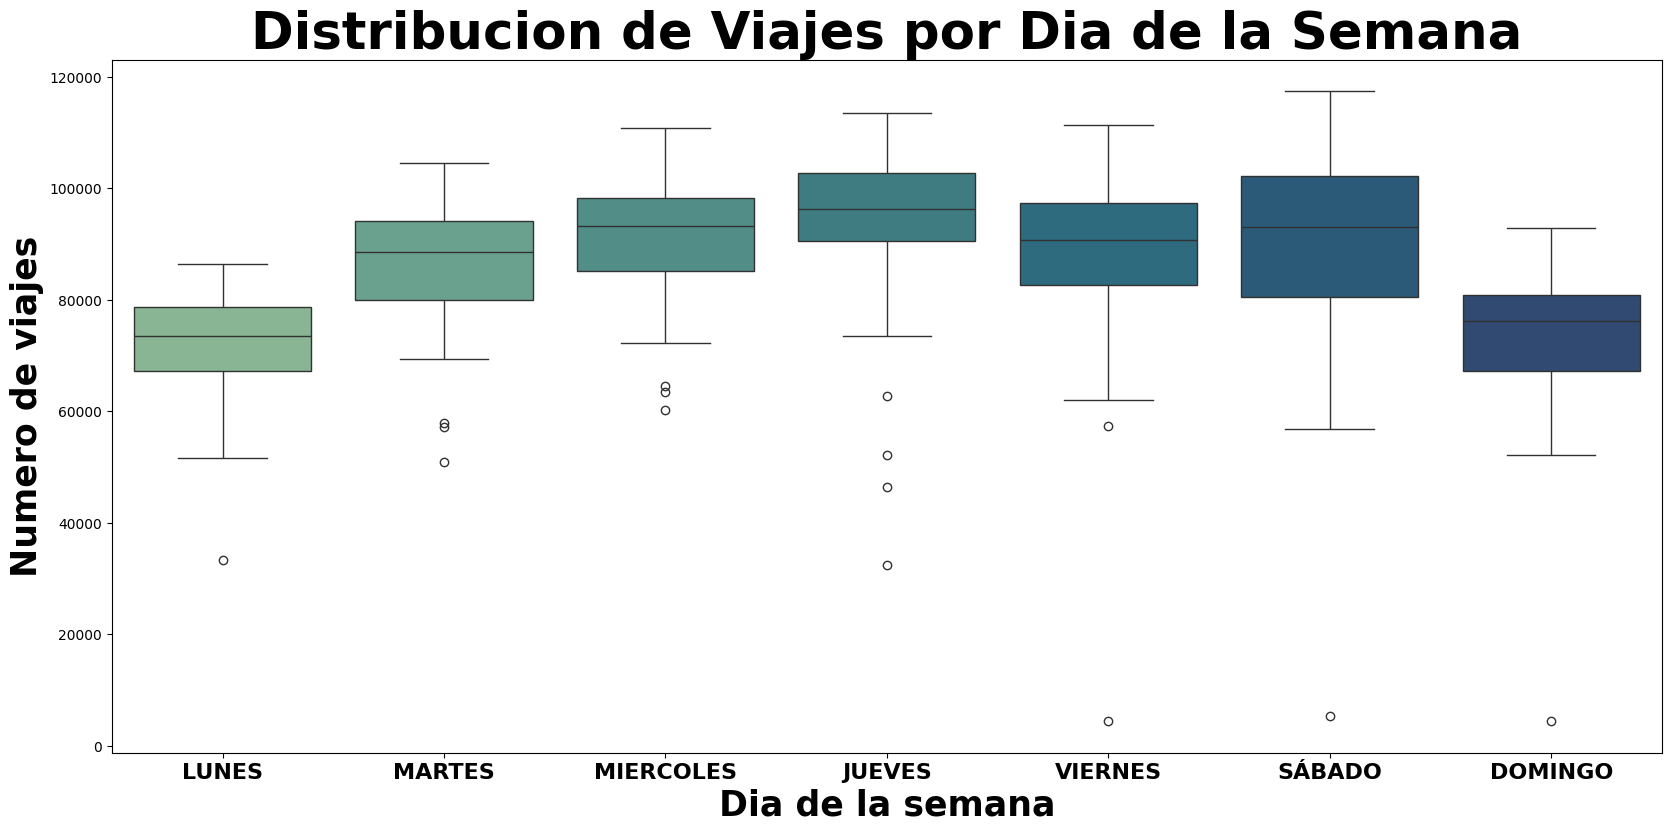

In [27]:
plt.figure(figsize = (20,9))
sns.boxplot(data=diario,x=diario.index.weekday,y= diario.n_trips, palette='crest')
plt.title('Distribucion de Viajes por Dia de la Semana',fontsize = 37,fontweight='bold')
plt.xlabel('Dia de la semana',fontsize = 25,fontweight='bold')
plt.ylabel('Numero de viajes',fontsize = 25,fontweight='bold')
plt.xticks(ticks=range(0,7), labels=['LUNES','MARTES','MIERCOLES','JUEVES','VIERNES','SÁBADO','DOMINGO'],fontsize = 16,fontweight='bold')
plt.show()

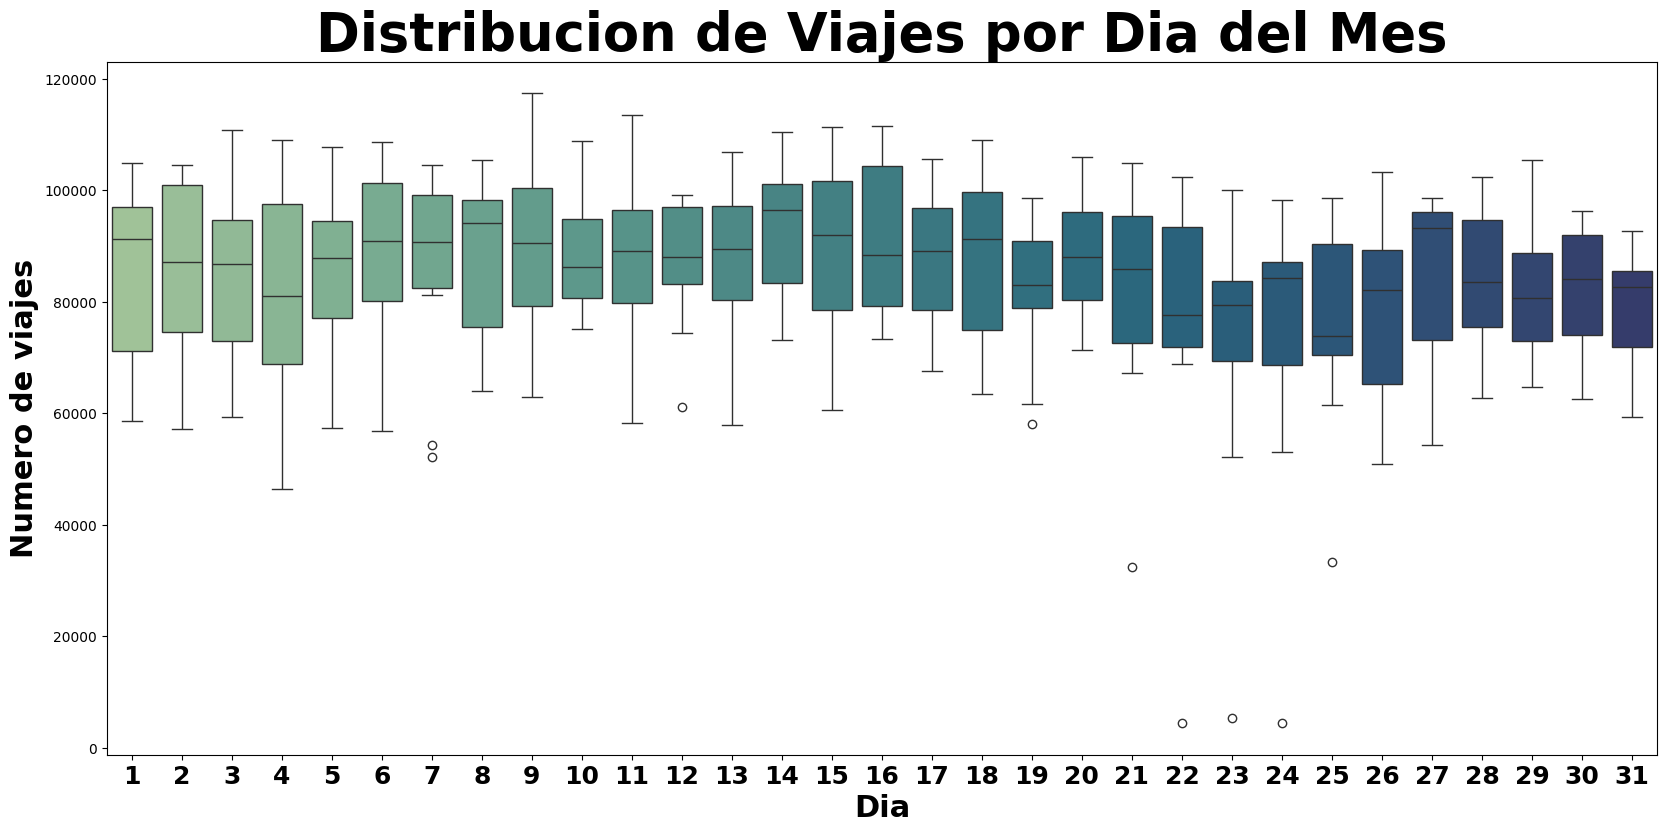

In [28]:
plt.figure(figsize = (20,9))
sns.boxplot(data=diario,x=diario.index.day,y= diario.n_trips, palette='crest')
plt.title('Distribucion de Viajes por Dia del Mes',fontsize = 38,fontweight='bold')
plt.xlabel('Dia',fontsize = 22,fontweight='bold')
plt.ylabel('Numero de viajes',fontsize = 22,fontweight='bold')
plt.xticks(fontsize = 18,fontweight='bold')
plt.show()

Se revisa si existen valores para todo el año de análisis (año bisiesto)

In [29]:
diario.shape[0]

366

In [ ]:
#diario.to_csv('raw/diario.csv')
#semanal.to_csv('raw/semanal.csv')
#mensual.to_csv('raw/mensual.csv')

In [3]:
diario = pd.read_csv('raw/diario.csv')
semanal = pd.read_csv('raw/semanal.csv')
mensual = pd.read_csv('raw/mensual.csv')

In [8]:
diario['pickup_datetime'] = pd.to_datetime(diario['pickup_datetime'])
semanal['pickup_datetime'] = pd.to_datetime(semanal['pickup_datetime'])
mensual['pickup_datetime'] = pd.to_datetime(mensual['pickup_datetime'])

In [9]:
diario.set_index('pickup_datetime', inplace=True)
mensual.set_index('pickup_datetime', inplace=True)
semanal.set_index('pickup_datetime', inplace=True)

In [10]:
diario

,passenger_count,trip_distance,total_amount,duration,n_trips
pickup_datetime,,,,,
2023-09-01,89276,110263.96,1276806.75,732888.533333,65751
2023-09-02,93982,112062.43,1198955.93,688208.400000,63961
2023-09-03,86499,103670.07,1105305.60,623286.116667,59323
2023-09-04,72679,89044.48,925141.30,486316.350000,51608
2023-09-05,99802,125552.34,1540935.85,897552.166667,78924
...,...,...,...,...,...
2024-08-27,91633,120296.62,1418567.88,824168.966667,73266
2024-08-28,101202,130843.35,1570150.82,920402.516667,81088
2024-08-29,96395,124708.58,1498053.45,894715.883333,76483


In [11]:
semanal

,passenger_count,trip_distance,total_amount,duration,n_trips
pickup_datetime,,,,,
2023-09-03,269789,326037.65,3581465.58,2.044612e+06,189053
2023-09-10,774580,941741.78,11635454.86,6.986193e+06,588642
2023-09-17,782870,959974.79,12179688.56,7.395936e+06,606553
2023-09-24,341409,416200.11,5594414.93,3.412822e+06,276622
2023-10-01,771602,944911.79,11838656.66,7.086461e+06,595336
2023-10-08,801099,981060.43,12204336.29,7.349261e+06,611780
2023-10-15,792958,965088.12,12042382.50,7.287548e+06,604932
2023-10-22,833690,1025976.55,12831777.30,7.789044e+06,638659
2023-10-29,838860,1030375.53,12954809.18,7.852571e+06,643674


In [12]:
mensual

,passenger_count,trip_distance,total_amount,duration,n_trips
pickup_datetime,,,,,
2023-09-30,2834965,3460189.95,43351361.13,2.606321e+07,2179200
2023-10-31,3576133,4382900.21,54676872.61,3.301915e+07,2736389
2023-11-30,3427883,4139501.57,51979545.55,3.135258e+07,2616757
2023-12-31,3541070,4167204.54,51955671.11,3.122333e+07,2625768
2024-01-31,3104773,3883527.49,46044469.28,2.626918e+07,2409342
2024-02-29,3124501,3959766.71,47253940.40,2.747364e+07,2448952
2024-03-31,3628203,4703052.88,55237790.42,3.265720e+07,2858661
2024-04-30,3513134,4646128.88,54112655.33,3.226751e+07,2777362
2024-05-31,3665269,4793006.98,57431400.26,3.453748e+07,2899539


## Interpolacion

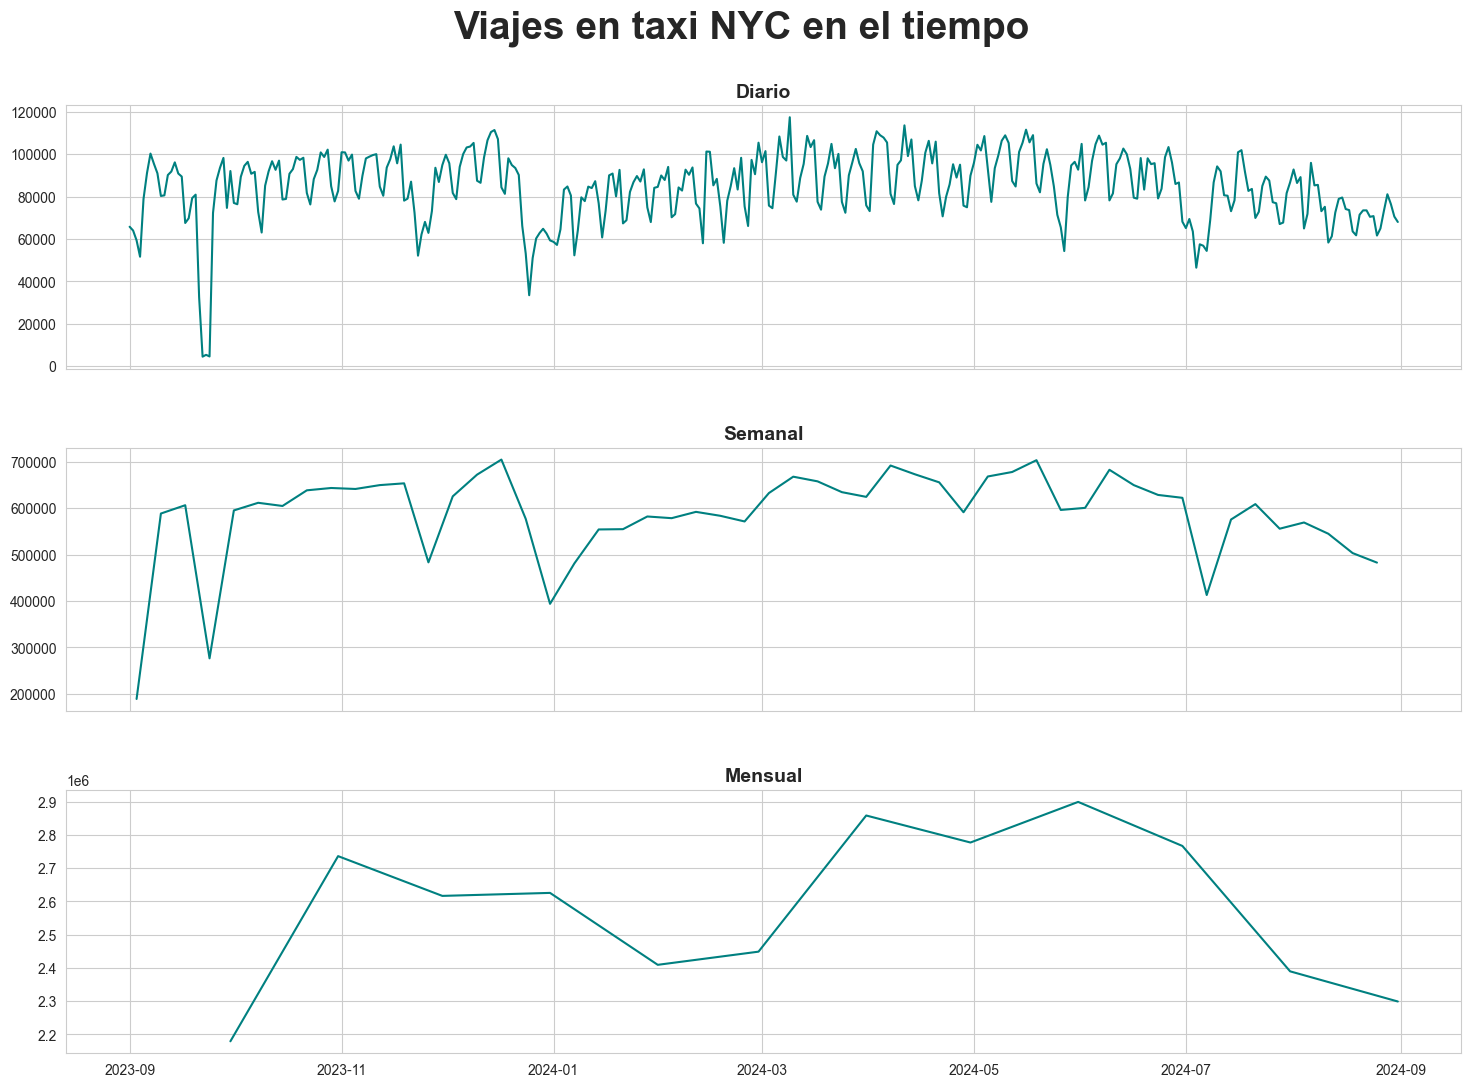

In [13]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(3,1, figsize = (18,12), gridspec_kw={'height_ratios': [1, 1, 1]}, sharex=True)
fig.suptitle("Viajes en taxi NYC en el tiempo",fontsize=28, fontweight='bold')
plt.subplots_adjust(top=0.9,hspace=0.3)

ax[2].plot(mensual.index, mensual.n_trips, color='teal')
ax[2].set_title('Mensual',fontsize=14, fontweight='bold')

ax[1].plot(semanal.index, semanal.n_trips, color='teal')
ax[1].set_title('Semanal',fontsize=14, fontweight='bold')

ax[0].plot(diario.index, diario.n_trips, color='teal')
ax[0].set_title('Diario',fontsize=14, fontweight='bold')



plt.show()

### Diario

In [14]:
pd.set_option('display.max_rows', None)
print(diario['n_trips'])
pd.reset_option('display.max_rows')

pickup_datetime
2023-09-01     65751
2023-09-02     63961
2023-09-03     59323
2023-09-04     51608
2023-09-05     78924
2023-09-06     91117
2023-09-07    100287
2023-09-08     95452
2023-09-09     90972
2023-09-10     80282
2023-09-11     80573
2023-09-12     90172
2023-09-13     91818
2023-09-14     96147
2023-09-15     90881
2023-09-16     89436
2023-09-17     67526
2023-09-18     69742
2023-09-19     79270
2023-09-20     80899
2023-09-21     32499
2023-09-22      4424
2023-09-23      5277
2023-09-24      4511
2023-09-25     72262
2023-09-26     87576
2023-09-27     93566
2023-09-28     98244
2023-09-29     74648
2023-09-30     92052
2023-10-01     76988
2023-10-02     76369
2023-10-03     89334
2023-10-04     94494
2023-10-05     96391
2023-10-06     90756
2023-10-07     91654
2023-10-08     72782
2023-10-09     63026
2023-10-10     85145
2023-10-11     91896
2023-10-12     96675
2023-10-13     92624
2023-10-14     96969
2023-10-15     78597
2023-10-16     78880
2023-10-17     907

In [15]:
diario.drop(diario[diario.index <= '2023-09-04'].index, inplace=True)

Se interpolan valores para los rangos que presentan variaciones muy bruscas. Estos periodos fueron los siguientes:<br>
- 2023-09-21 a 2023-09-24
- 2023-12-24 a 2023-12-26
- 2024-05-27
- 2024-07-04 a 2024-07-07

In [16]:
diario[((diario.index>='2023-09-21')&(diario.index<='2023-09-24'))
       |((diario.index>='2023-12-24')&(diario.index<='2023-12-26'))
       |(diario.index== '2024-05-27')
       |((diario.index>='2024-07-04')&(diario.index<='2024-07-07'))]

,passenger_count,trip_distance,total_amount,duration,n_trips
pickup_datetime,,,,,
2023-09-21,38739,48265.04,636467.92,402893.950000,32499
2023-09-22,4703,5097.96,92734.44,60287.916667,4424
2023-09-23,5535,6464.68,111160.33,71610.133333,5277
2023-09-24,4723,5538.31,90399.57,54416.266667,4511
2023-12-24,79098,86938.73,951568.76,533378.416667,53102
2023-12-25,49926,58090.96,612017.09,338687.666667,33419
2023-12-26,75129,84486.54,992525.42,575846.683333,50998
2024-05-27,73550,94481.25,965690.79,526340.433333,54276
2024-07-04,65340,80787.20,840068.38,466952.533333,46431


In [17]:
diario.loc[
    ((diario.index >= '2023-09-21') & (diario.index <= '2023-09-24')) |
    ((diario.index >= '2023-12-24') & (diario.index <= '2023-12-26')) |
    (diario.index == '2024-05-27') |
    ((diario.index >= '2024-07-04') & (diario.index <= '2024-07-07')),
    'n_trips'
] = np.nan

In [19]:
diario[((diario.index>='2023-09-21')&(diario.index<='2023-09-24'))
       |((diario.index>='2023-12-24')&(diario.index<='2023-12-26'))
       |(diario.index== '2024-05-27')
       |((diario.index>='2024-07-04')&(diario.index<='2024-07-07'))]

,passenger_count,trip_distance,total_amount,duration,n_trips
pickup_datetime,,,,,
2023-09-21,38739,48265.04,636467.92,402893.950000,NaN
2023-09-22,4703,5097.96,92734.44,60287.916667,NaN
2023-09-23,5535,6464.68,111160.33,71610.133333,NaN
2023-09-24,4723,5538.31,90399.57,54416.266667,NaN
2023-12-24,79098,86938.73,951568.76,533378.416667,NaN
2023-12-25,49926,58090.96,612017.09,338687.666667,NaN
2023-12-26,75129,84486.54,992525.42,575846.683333,NaN
2024-05-27,73550,94481.25,965690.79,526340.433333,NaN
2024-07-04,65340,80787.20,840068.38,466952.533333,NaN


In [41]:
diario.isnull().sum()

passenger_count     0
trip_distance       0
total_amount        0
duration            0
n_trips            12
dtype: int64

In [20]:
diario = diario.interpolate() 

In [43]:
diario.isnull().sum()

passenger_count    0
trip_distance      0
total_amount       0
duration           0
n_trips            0
dtype: int64

In [21]:
diario[(diario.index== '2023-09-04')|((diario.index>='2023-09-21')&(diario.index<='2023-09-24'))
       |((diario.index>='2023-12-24')&(diario.index<='2023-12-26'))
       |(diario.index== '2024-05-27')
       |((diario.index>='2024-07-04')&(diario.index<='2024-07-07'))]

,passenger_count,trip_distance,total_amount,duration,n_trips
pickup_datetime,,,,,
2023-09-21,38739,48265.04,636467.92,402893.950000,79171.6
2023-09-22,4703,5097.96,92734.44,60287.916667,77444.2
2023-09-23,5535,6464.68,111160.33,71610.133333,75716.8
2023-09-24,4723,5538.31,90399.57,54416.266667,73989.4
2023-12-24,79098,86938.73,951568.76,533378.416667,64664.5
2023-12-25,49926,58090.96,612017.09,338687.666667,63180.0
2023-12-26,75129,84486.54,992525.42,575846.683333,61695.5
2024-05-27,73550,94481.25,965690.79,526340.433333,72630.0
2024-07-04,65340,80787.20,840068.38,466952.533333,64570.4


### Semanal

In [22]:
semanal = diario.resample('W').sum()

In [23]:
semanal.head(50)

,passenger_count,trip_distance,total_amount,duration,n_trips
pickup_datetime,,,,,
2023-09-10,701901,852697.30,10710313.56,6.499876e+06,537034.0
2023-09-17,782870,959974.79,12179688.56,7.395936e+06,606553.0
2023-09-24,341409,416200.11,5594414.93,3.412822e+06,536233.0
2023-10-01,771602,944911.79,11838656.66,7.086461e+06,595336.0
2023-10-08,801099,981060.43,12204336.29,7.349261e+06,611780.0
2023-10-15,792958,965088.12,12042382.50,7.287548e+06,604932.0
2023-10-22,833690,1025976.55,12831777.30,7.789044e+06,638659.0
2023-10-29,838860,1030375.53,12954809.18,7.852571e+06,643674.0
2023-11-05,841134,1022938.51,12805134.84,7.717200e+06,641573.0


Se interpolan valores para los rangos que presentan variaciones muy bruscas. Estos periodos fueron los siguientes:<br>
- 2023-11-26
- 2023-12-31
- 2024-07-07

In [24]:
semanal.drop(semanal.index[0], inplace=True)

In [25]:
semanal[semanal['n_trips']<550000]

,passenger_count,trip_distance,total_amount,duration,n_trips
pickup_datetime,,,,,
2023-09-24,341409,416200.11,5594414.93,3.412822e+06,536233.0
2023-11-26,669163,753793.00,9350633.25,5.535673e+06,483449.0
2023-12-31,578478,646689.94,7548111.24,4.411423e+06,434526.5
2024-01-07,650076,799276.23,9079098.07,5.056719e+06,481121.0
2024-07-07,557510,691096.70,7739944.86,4.396610e+06,462676.0
2024-08-11,694209,892107.94,10652686.93,6.345388e+06,545072.0
2024-08-18,649747,834644.35,9697601.11,5.644428e+06,503388.0
2024-08-25,625485,804600.84,9313993.24,5.427057e+06,482889.0
2024-09-01,561225,718228.87,8338869.26,4.868650e+06,434325.0


In [26]:
semanal[(semanal.index== '2023-11-26')
       |(semanal.index== '2023-12-31')
       |(semanal.index=='2024-07-07')]

,passenger_count,trip_distance,total_amount,duration,n_trips
pickup_datetime,,,,,
2023-11-26,669163,753793.00,9350633.25,5.535673e+06,483449.0
2023-12-31,578478,646689.94,7548111.24,4.411423e+06,434526.5
2024-07-07,557510,691096.70,7739944.86,4.396610e+06,462676.0


In [27]:
semanal.loc[(semanal.index== '2023-11-26')
            |(semanal.index== '2023-12-31')
            |(semanal.index=='2024-07-07'),
            'n_trips'
            ] = np.nan

In [28]:
semanal = semanal.interpolate() 

In [29]:
semanal.isnull().sum()

passenger_count    0
trip_distance      0
total_amount       0
duration           0
n_trips            0
dtype: int64

In [30]:
semanal[(semanal.index== '2023-11-26')
        |(semanal.index== '2023-12-31')
        |(semanal.index=='2024-07-07')]

,passenger_count,trip_distance,total_amount,duration,n_trips
pickup_datetime,,,,,
2023-11-26,669163,753793.00,9350633.25,5.535673e+06,639688.00
2023-12-31,578478,646689.94,7548111.24,4.411423e+06,534932.75
2024-07-07,557510,691096.70,7739944.86,4.396610e+06,599126.00


In [31]:
semanal

,passenger_count,trip_distance,total_amount,duration,n_trips
pickup_datetime,,,,,
2023-09-17,782870,959974.79,12179688.56,7.395936e+06,606553.00
2023-09-24,341409,416200.11,5594414.93,3.412822e+06,536233.00
2023-10-01,771602,944911.79,11838656.66,7.086461e+06,595336.00
2023-10-08,801099,981060.43,12204336.29,7.349261e+06,611780.00
2023-10-15,792958,965088.12,12042382.50,7.287548e+06,604932.00
2023-10-22,833690,1025976.55,12831777.30,7.789044e+06,638659.00
2023-10-29,838860,1030375.53,12954809.18,7.852571e+06,643674.00
2023-11-05,841134,1022938.51,12805134.84,7.717200e+06,641573.00
2023-11-12,842513,1034821.18,12925628.45,7.903845e+06,649886.00


In [32]:
semanal.drop(semanal[semanal.index >= '2024-08-11'].index,inplace=True)

### Mensual

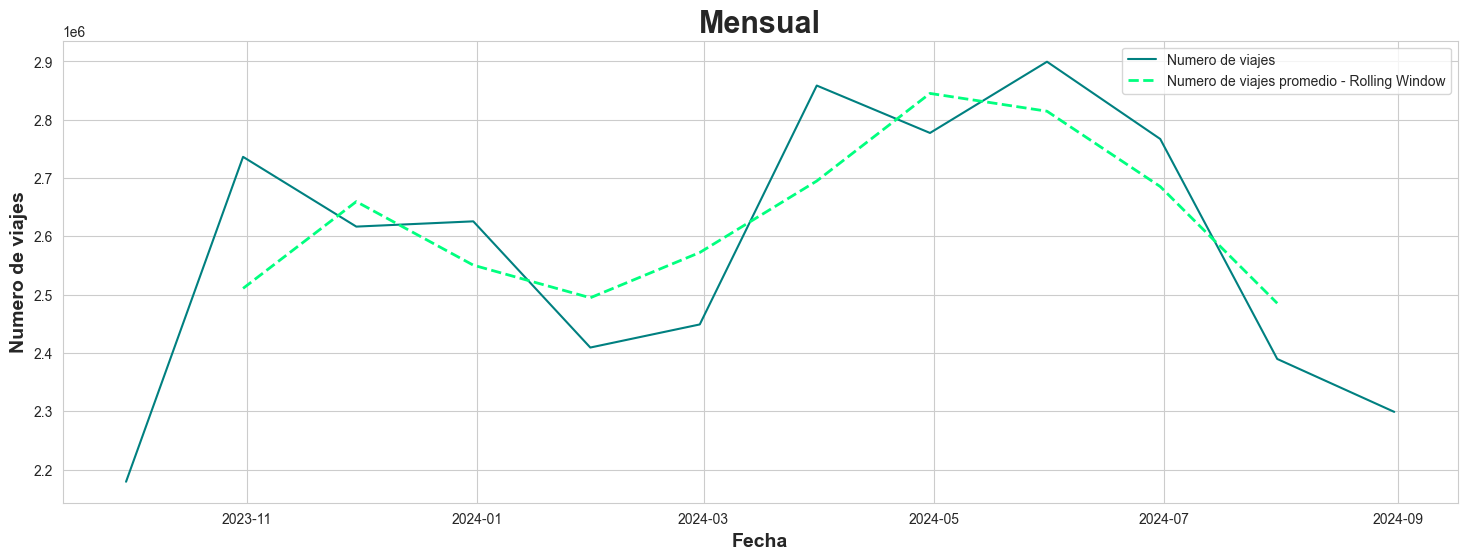

In [33]:
plt.figure(figsize=(18,6))
ventana = (3)
mensual_promedio_tendencia = mensual.n_trips.rolling(window=ventana, center = True).mean()
plt.plot(mensual.index, mensual.n_trips, label = 'Numero de viajes', color='teal')
plt.plot(mensual_promedio_tendencia, lw = 2, linestyle="--", label = 'Numero de viajes promedio - Rolling Window', color='springgreen')
plt.xlabel('Fecha',fontsize=14, fontweight='bold')
plt.ylabel('Numero de viajes',fontsize=14, fontweight='bold')
plt.title('Mensual',fontsize=22, fontweight='bold')
plt.legend()

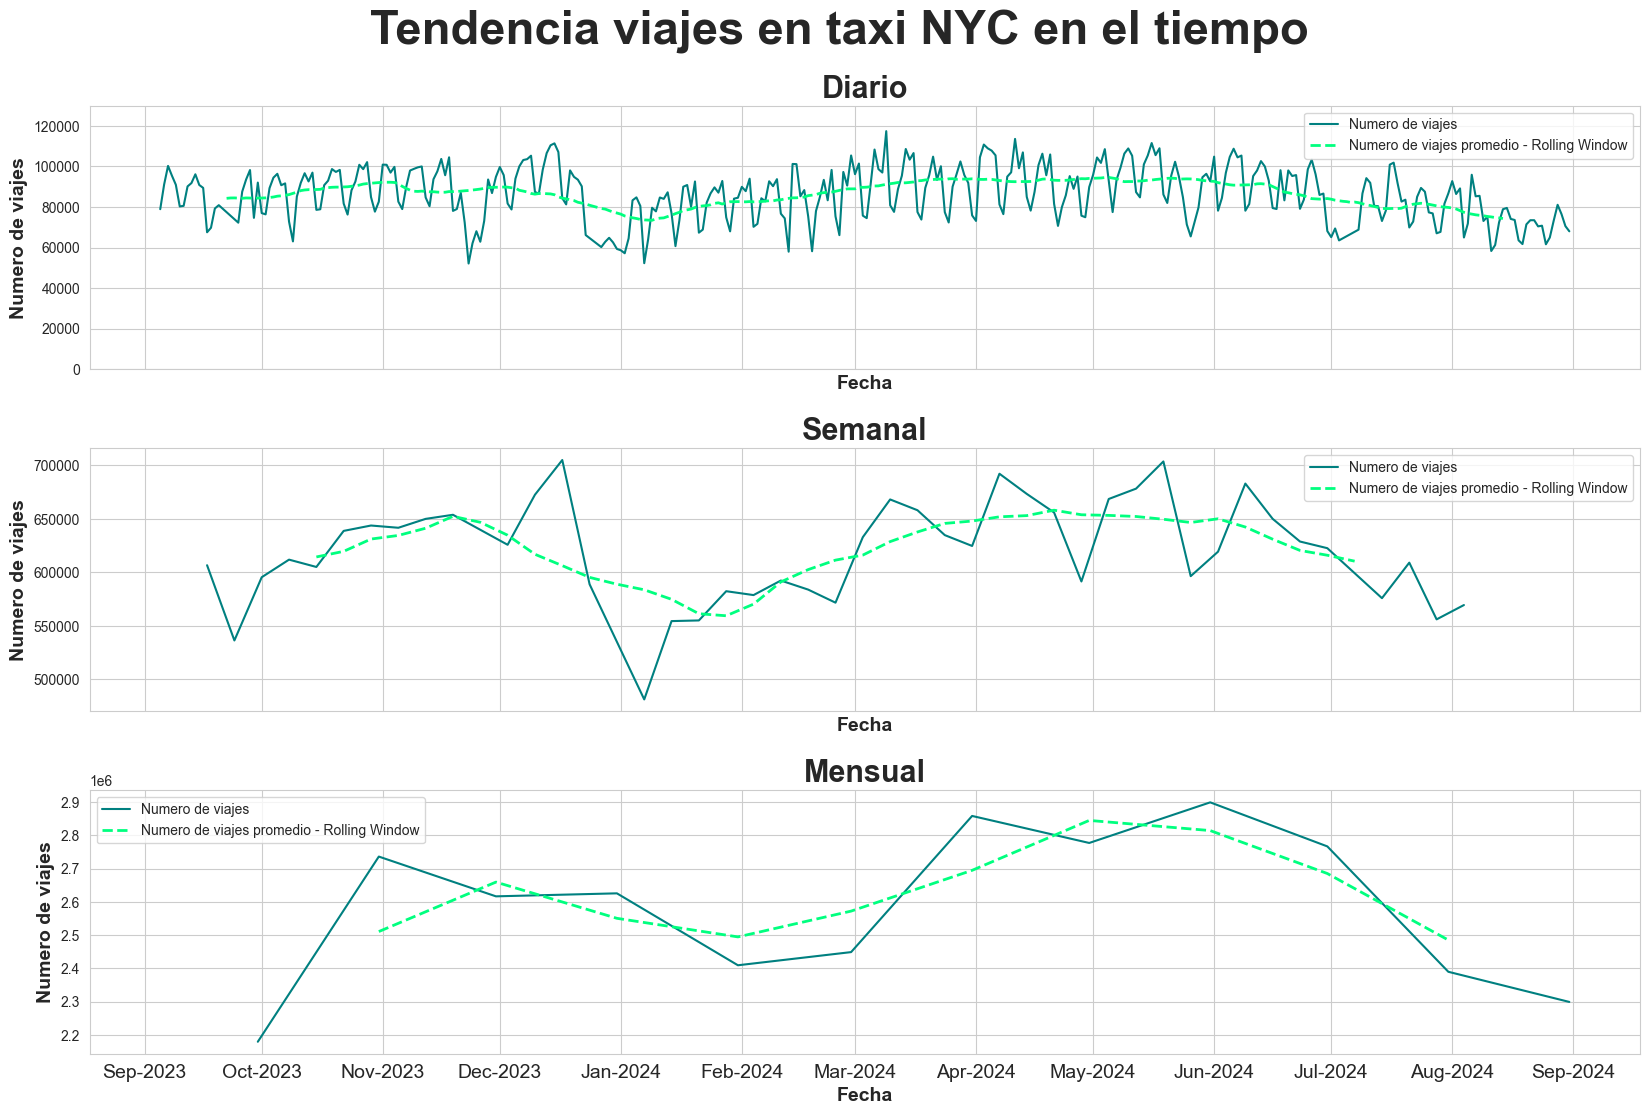

In [34]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(3,1, figsize = (20,12), gridspec_kw={'height_ratios': [1, 1, 1]}, sharex=True)
fig.suptitle("Tendencia viajes en taxi NYC en el tiempo",fontsize=34, fontweight='bold')
plt.subplots_adjust(top=0.9,hspace=0.3)

ax[-1].tick_params(axis='x', labelsize=14)
ax[-1].xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax[-1].xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 

ventana = (35)
diario_promedio_tendencia = diario.n_trips.rolling(window=ventana, center = True).mean()
ax[0].plot(diario.index, diario.n_trips, label = 'Numero de viajes', color='teal')
ax[0].plot(diario_promedio_tendencia, lw = 2, linestyle="--", label = 'Numero de viajes promedio - Rolling Window', color='springgreen')
ax[0].set_xlabel('Fecha',fontsize=14, fontweight='bold')
ax[0].set_ylabel('Numero de viajes',fontsize=14, fontweight='bold')
ax[0].set_title('Diario',fontsize=22, fontweight='bold')
ax[0].set_ylim(0,130000)
ax[0].legend()

ventana = (9)
semanal_promedio_tendencia = semanal.n_trips.rolling(window=ventana, center = True).mean()
ax[1].plot(semanal.index, semanal.n_trips, label = 'Numero de viajes', color='teal')
ax[1].plot(semanal_promedio_tendencia, lw = 2, linestyle="--", label = 'Numero de viajes promedio - Rolling Window', color='springgreen')
ax[1].set_xlabel('Fecha',fontsize=14, fontweight='bold')
ax[1].set_ylabel('Numero de viajes',fontsize=14, fontweight='bold')
ax[1].set_title('Semanal',fontsize=22, fontweight='bold')
ax[1].legend()

ventana = (3)
mensual_promedio_tendencia = mensual.n_trips.rolling(window=ventana, center = True).mean()
ax[2].plot(mensual.index, mensual.n_trips, label = 'Numero de viajes', color='teal')
ax[2].plot(mensual_promedio_tendencia, lw = 2, linestyle="--", label = 'Numero de viajes promedio - Rolling Window', color='springgreen')
ax[2].set_xlabel('Fecha',fontsize=14, fontweight='bold')
ax[2].set_ylabel('Numero de viajes',fontsize=14, fontweight='bold')
ax[2].set_title('Mensual',fontsize=22, fontweight='bold')
ax[2].legend()


plt.show()

In [35]:
result_d = seasonal_decompose(diario.n_trips, model='additive')

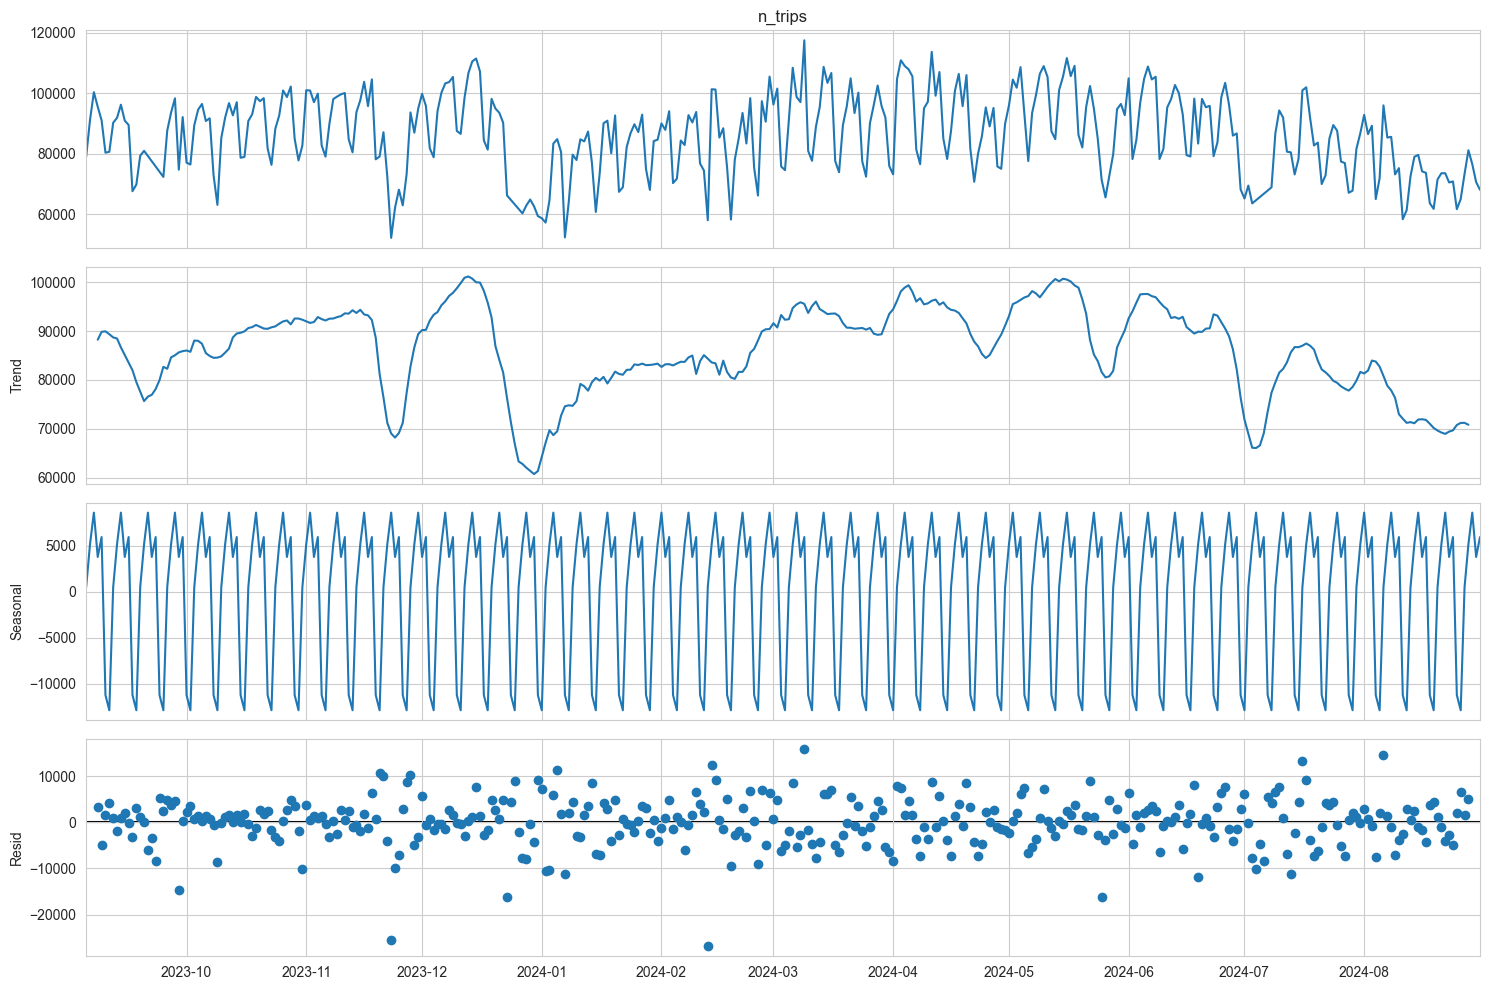

In [36]:
matplotlib.rcParams['figure.figsize'] = [15,10]
result_d.plot()
plt.show()


## Estacionariedad

In [37]:
#H0: No es estacionaria
#H1: Es estacionaria
def adfuller_test(trips):
    result = adfuller(trips)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print('Es estacionaria.')
    else:
        print('No es estacionaria.')

In [38]:
adfuller_test(diario.n_trips)

ADF Test Statistic : -3.2533311588830793
p-value : 0.01709788957198192
#Lags Used : 15
Number of Observations Used : 346
Es estacionaria.


In [39]:
adfuller_test(semanal.n_trips)

ADF Test Statistic : -3.215599850834485
p-value : 0.019099270845996216
#Lags Used : 0
Number of Observations Used : 46
Es estacionaria.


In [40]:
adfuller_test(mensual.n_trips)

ADF Test Statistic : -1.6094009864898395
p-value : 0.47886955144977916
#Lags Used : 3
Number of Observations Used : 8
No es estacionaria.


In [41]:
diario.to_csv('diario_inter.csv')
semanal.to_csv('semanal_inter.csv')
# mensual.to_csv('mensual.csv')